In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import pandas as pd

In [2]:
warnings.filterwarnings("ignore")

# 创建数据集

## 从-3-3生成1000个总体点,模拟标准化后的数据

In [3]:
a = -3
b = 3
X = a+(b-a)*np.random.rand(1000, 1)

## 假定真实参数beta1=1，即y=X

In [4]:
y = X

## 实验重复1000次，每一次从总体抽取100个样本点，模拟有放回随机抽样

## 误差项Error为参数是0,1的正态分布

In [6]:
# 后续代码仅需修改第一行
y1_normal = y+np.random.normal(0, 1, size=y.shape)  # 引入误差项
lr_beta1, ransac_beta1, huber_beta1, theilsen_beta1 = [], [], [], []
lr_train_mse, ransac_train_mse, huber_train_mse, theilsen_train_mse = [], [], [], []
lr_test_mse, ransac_test_mse, huber_test_mse, theilsen_test_mse = [], [], [], []

# 将总体随机打乱，然后从中抽取100个样本


def select_samples(X, y):
    row_rand_array = np.arange(X.shape[0])
    np.random.shuffle(row_rand_array)
    X_samples = X[row_rand_array][:100]
    y_samples = y[row_rand_array][:100]
    return X_samples, y_samples


# 实验重复1000次，最后取平均值
while len(lr_beta1) < 1000:

    X_samples, y1_normal_samples = select_samples(X, y1_normal)
    # 100个样本点划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X_samples, y1_normal_samples, test_size=0.2)

    # 在训练集中加入异常值干扰
    n_outliers = 10
    X_train[:n_outliers] = 3+0.5*np.random.normal(size=(n_outliers, 1))
    y_train[:n_outliers] = -3+10*np.random.normal(size=(n_outliers, 1))

    # 普通OLS回归
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    lr_beta1.append(lr.coef_)
    # 计算训练集和测试集的均方误差MSE
    lr_train_mse.append(mean_squared_error(
        y_train, lr.predict(X_train), squared=False))
    lr_test_mse.append(mean_squared_error(
        y_test, lr.predict(X_test), squared=False))

    # Ransac回归
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X_train, y_train)
    ransac_beta1.append(ransac.estimator_.coef_)
    # 计算训练集和测试集的均方误差MSE
    ransac_train_mse.append(mean_squared_error(
        y_train, ransac.predict(X_train), squared=False))
    ransac_test_mse.append(mean_squared_error(
        y_test, ransac.predict(X_test), squared=False))

    # Huber回归
    huber = linear_model.HuberRegressor()
    huber.fit(X_train, y_train)
    huber_beta1.append(huber.coef_)
    # 计算训练集和测试集的均方误差MSE
    huber_train_mse.append(mean_squared_error(
        y_train, huber.predict(X_train), squared=False))
    huber_test_mse.append(mean_squared_error(
        y_test, huber.predict(X_test), squared=False))

    # Theilsen回归
    theilsen = linear_model.TheilSenRegressor()
    theilsen.fit(X_train, y_train)
    theilsen_beta1.append(theilsen.coef_)
    # 计算训练集和测试集的均方误差MSE
    theilsen_train_mse.append(mean_squared_error(
        y_train, theilsen.predict(X_train), squared=False))
    theilsen_test_mse.append(mean_squared_error(
        y_test, theilsen.predict(X_test), squared=False))

# 计算平均beta1，训练集MSE，测试集MSE


def cau_result(beta1, train_mse, test_mse):
    avg_beta1 = sum(beta1)/len(beta1)
    #avg_beta1 = avg_beta1[0][0]
    avg_train_mse = sum(train_mse) / len(train_mse)
    avg_test_mse = sum(test_mse) / len(test_mse)
    return avg_beta1, avg_train_mse, avg_test_mse


# 线性回归结果
lr_avg_beta1, lr_avg_train_mse, lr_avg_test_mse = cau_result(
    lr_beta1, lr_train_mse, lr_test_mse)

# Ransac回归结果
ransac_avg_beta1, ransac_avg_train_mse, ransac_avg_test_mse = cau_result(
    ransac_beta1, ransac_train_mse, ransac_test_mse)

# Huber回归结果
huber_avg_beta1, huber_avg_train_mse, huber_avg_test_mse = cau_result(
    huber_beta1, huber_train_mse, huber_test_mse)

# Theilsen回归结果
theilsen_avg_beta1, theilsen_avg_train_mse, theilsen_avg_test_mse = cau_result(
    theilsen_beta1, theilsen_train_mse, theilsen_test_mse)

# 结果用DataFrame展示
result = pd.DataFrame(
    {"Avg_beta": [lr_avg_beta1[0][0], ransac_avg_beta1[0][0], huber_avg_beta1[0], theilsen_avg_beta1[0]],
     "Avg_train_mse": [lr_avg_train_mse, ransac_avg_train_mse, huber_avg_train_mse, theilsen_avg_train_mse],
     "Avg_test_mse": [lr_avg_test_mse, ransac_avg_test_mse, huber_avg_test_mse, theilsen_avg_test_mse]})
result.index = ["lr_reg", "ransac_reg", "huber_reg", "theilsen_reg"]
result

,Avg_beta,Avg_train_mse,Avg_test_mse
lr_reg,0.406263,3.904830,1.560144
ransac_reg,0.989113,4.171998,1.049232
huber_reg,0.885154,4.083436,1.036107
theilsen_reg,0.898475,4.103977,1.028350


# 绘制图进行对比

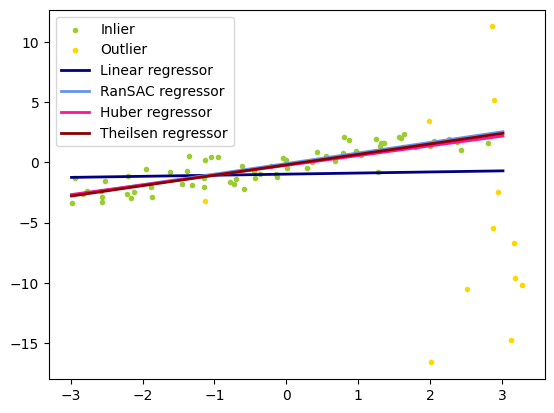

In [10]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(X_train.min(), X_train.max())[:, np.newaxis]
lr_y = lr.predict(line_X)
ransac_y = ransac.predict(line_X)
huber_y = huber.predict(line_X)
theilsen_y = theilsen.predict(line_X)

plt.scatter(X_train[inlier_mask], y_train[inlier_mask],
            color="yellowgreen", marker=".", label="Inlier")
plt.scatter(X_train[outlier_mask], y_train[outlier_mask],
            color="gold", marker=".", label="Outlier")


plt.plot(line_X, lr_y, color="navy", linewidth=2, label="Linear regressor")
plt.plot(line_X, ransac_y, color="cornflowerblue",
         linewidth=2, label="RanSAC regressor")
plt.plot(line_X, huber_y, color="deeppink",
         linewidth=2, label="Huber regressor")
plt.plot(line_X, theilsen_y, color="darkred",
         linewidth=2, label="Theilsen regressor")
plt.legend()

plt.show()

## 误差项Error为参数是0,3和0,1的混合正态分布

In [11]:
y2_combine_normal = y + 0.7 * \
    np.random.normal(0, 3, y.shape)+0.3 * \
    np.random.normal(0, 1, y.shape)
lr_beta1, ransac_beta1, huber_beta1, theilsen_beta1 = [], [], [], []
lr_train_mse, ransac_train_mse, huber_train_mse, theilsen_train_mse = [], [], [], []
lr_test_mse, ransac_test_mse, huber_test_mse, theilsen_test_mse = [], [], [], []
# 实验重复1000次，最后取平均值
while len(lr_beta1) < 1000:

    X_samples, y2_combine_normal_samples = select_samples(X, y2_combine_normal)
    # 100个样本点划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X_samples, y2_combine_normal_samples, test_size=0.2)

    # 在训练集中加入异常值干扰
    n_outliers = 10
    X_train[:n_outliers] = 3+0.5*np.random.normal(size=(n_outliers, 1))
    y_train[:n_outliers] = -3+10*np.random.normal(size=(n_outliers, 1))

    # 普通OLS回归
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    lr_beta1.append(lr.coef_)
    # 计算训练集和测试集的均方误差MSE
    lr_train_mse.append(mean_squared_error(
        y_train, lr.predict(X_train), squared=False))
    lr_test_mse.append(mean_squared_error(
        y_test, lr.predict(X_test), squared=False))

    # Ransac回归
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X_train, y_train)
    ransac_beta1.append(ransac.estimator_.coef_)
    # 计算训练集和测试集的均方误差MSE
    ransac_train_mse.append(mean_squared_error(
        y_train, ransac.predict(X_train), squared=False))
    ransac_test_mse.append(mean_squared_error(
        y_test, ransac.predict(X_test), squared=False))

    # Huber回归
    huber = linear_model.HuberRegressor()
    huber.fit(X_train, y_train)
    huber_beta1.append(huber.coef_)
    # 计算训练集和测试集的均方误差MSE
    huber_train_mse.append(mean_squared_error(
        y_train, huber.predict(X_train), squared=False))
    huber_test_mse.append(mean_squared_error(
        y_test, huber.predict(X_test), squared=False))

    # Theilsen回归
    theilsen = linear_model.TheilSenRegressor()
    theilsen.fit(X_train, y_train)
    theilsen_beta1.append(theilsen.coef_)
    # 计算训练集和测试集的均方误差MSE
    theilsen_train_mse.append(mean_squared_error(
        y_train, theilsen.predict(X_train), squared=False))
    theilsen_test_mse.append(mean_squared_error(
        y_test, theilsen.predict(X_test), squared=False))


def cau_result(beta1, train_mse, test_mse):
    avg_beta1 = sum(beta1)/len(beta1)
    #avg_beta1 = avg_beta1[0][0]
    avg_train_mse = sum(train_mse) / len(train_mse)
    avg_test_mse = sum(test_mse) / len(test_mse)
    return avg_beta1, avg_train_mse, avg_test_mse


# 线性回归结果
lr_avg_beta1, lr_avg_train_mse, lr_avg_test_mse = cau_result(
    lr_beta1, lr_train_mse, lr_test_mse)

# Ransac回归结果
ransac_avg_beta1, ransac_avg_train_mse, ransac_avg_test_mse = cau_result(
    ransac_beta1, ransac_train_mse, ransac_test_mse)

# Huber回归结果
huber_avg_beta1, huber_avg_train_mse, huber_avg_test_mse = cau_result(
    huber_beta1, huber_train_mse, huber_test_mse)

# Theilsen回归结果
theilsen_avg_beta1, theilsen_avg_train_mse, theilsen_avg_test_mse = cau_result(
    theilsen_beta1, theilsen_train_mse, theilsen_test_mse)

result = pd.DataFrame(
    {"Avg_beta": [lr_avg_beta1[0][0], ransac_avg_beta1[0][0], huber_avg_beta1[0], theilsen_avg_beta1[0]],
     "Avg_train_mse": [lr_avg_train_mse, ransac_avg_train_mse, huber_avg_train_mse, theilsen_avg_train_mse],
     "Avg_test_mse": [lr_avg_test_mse, ransac_avg_test_mse, huber_avg_test_mse, theilsen_avg_test_mse]})
result.index = ["lr_reg", "ransac_reg", "huber_reg", "theilsen_reg"]
result

,Avg_beta,Avg_train_mse,Avg_test_mse
lr_reg,0.435955,4.293520,2.467910
ransac_reg,0.936821,4.567785,2.292062
huber_reg,0.794910,4.396089,2.218476
theilsen_reg,0.810030,4.440458,2.209103


## 误差项Error为参数是0,1的拉普拉斯分布

In [12]:
y3_laplace = y + np.random.laplace(0, 1, y.shape)
lr_beta1, ransac_beta1, huber_beta1, theilsen_beta1 = [], [], [], []
lr_train_mse, ransac_train_mse, huber_train_mse, theilsen_train_mse = [], [], [], []
lr_test_mse, ransac_test_mse, huber_test_mse, theilsen_test_mse = [], [], [], []
# 实验重复1000次，最后取平均值
while len(lr_beta1) < 1000:

    X_samples, y3_laplace_samples = select_samples(X, y3_laplace)
    # 100个样本点划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X_samples, y3_laplace_samples, test_size=0.2)

    # 在训练集中加入异常值干扰
    n_outliers = 10
    X_train[:n_outliers] = 3+0.5*np.random.normal(size=(n_outliers, 1))
    y_train[:n_outliers] = -3+10*np.random.normal(size=(n_outliers, 1))

    # 普通OLS回归
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    lr_beta1.append(lr.coef_)
    # 计算训练集和测试集的均方误差MSE
    lr_train_mse.append(mean_squared_error(
        y_train, lr.predict(X_train), squared=False))
    lr_test_mse.append(mean_squared_error(
        y_test, lr.predict(X_test), squared=False))

    # Ransac回归
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X_train, y_train)
    ransac_beta1.append(ransac.estimator_.coef_)
    # 计算训练集和测试集的均方误差MSE
    ransac_train_mse.append(mean_squared_error(
        y_train, ransac.predict(X_train), squared=False))
    ransac_test_mse.append(mean_squared_error(
        y_test, ransac.predict(X_test), squared=False))

    # Huber回归
    huber = linear_model.HuberRegressor()
    huber.fit(X_train, y_train)
    huber_beta1.append(huber.coef_)
    # 计算训练集和测试集的均方误差MSE
    huber_train_mse.append(mean_squared_error(
        y_train, huber.predict(X_train), squared=False))
    huber_test_mse.append(mean_squared_error(
        y_test, huber.predict(X_test), squared=False))

    # Theilsen回归
    theilsen = linear_model.TheilSenRegressor()
    theilsen.fit(X_train, y_train)
    theilsen_beta1.append(theilsen.coef_)
    # 计算训练集和测试集的均方误差MSE
    theilsen_train_mse.append(mean_squared_error(
        y_train, theilsen.predict(X_train), squared=False))
    theilsen_test_mse.append(mean_squared_error(
        y_test, theilsen.predict(X_test), squared=False))


def cau_result(beta1, train_mse, test_mse):
    avg_beta1 = sum(beta1)/len(beta1)
    #avg_beta1 = avg_beta1[0][0]
    avg_train_mse = sum(train_mse) / len(train_mse)
    avg_test_mse = sum(test_mse) / len(test_mse)
    return avg_beta1, avg_train_mse, avg_test_mse


# 线性回归结果
lr_avg_beta1, lr_avg_train_mse, lr_avg_test_mse = cau_result(
    lr_beta1, lr_train_mse, lr_test_mse)

# Ransac回归结果
ransac_avg_beta1, ransac_avg_train_mse, ransac_avg_test_mse = cau_result(
    ransac_beta1, ransac_train_mse, ransac_test_mse)

# Huber回归结果
huber_avg_beta1, huber_avg_train_mse, huber_avg_test_mse = cau_result(
    huber_beta1, huber_train_mse, huber_test_mse)

# Theilsen回归结果
theilsen_avg_beta1, theilsen_avg_train_mse, theilsen_avg_test_mse = cau_result(
    theilsen_beta1, theilsen_train_mse, theilsen_test_mse)

result = pd.DataFrame(
    {"Avg_beta": [lr_avg_beta1[0][0], ransac_avg_beta1[0][0], huber_avg_beta1[0], theilsen_avg_beta1[0]],
     "Avg_train_mse": [lr_avg_train_mse, ransac_avg_train_mse, huber_avg_train_mse, theilsen_avg_train_mse],
     "Avg_test_mse": [lr_avg_test_mse, ransac_avg_test_mse, huber_avg_test_mse, theilsen_avg_test_mse]})
result.index = ["lr_reg", "ransac_reg", "huber_reg", "theilsen_reg"]
result

,Avg_beta,Avg_train_mse,Avg_test_mse
lr_reg,0.402018,4.029153,1.854961
ransac_reg,1.010113,4.315490,1.429754
huber_reg,0.881284,4.204206,1.421957
theilsen_reg,0.919680,4.242684,1.410430


## 误差项Error为标准柯西分布

In [13]:
y4_standard_cauchy = y+np.random.standard_cauchy(size=y.shape)
lr_beta1, ransac_beta1, huber_beta1, theilsen_beta1 = [], [], [], []
lr_train_mse, ransac_train_mse, huber_train_mse, theilsen_train_mse = [], [], [], []
lr_test_mse, ransac_test_mse, huber_test_mse, theilsen_test_mse = [], [], [], []
# 实验重复1000次，最后取平均值
while len(lr_beta1) < 1000:

    X_samples, y4_standard_cauchy_samples = select_samples(
        X, y4_standard_cauchy)
    # 100个样本点划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X_samples, y4_standard_cauchy_samples, test_size=0.2)

    # 在训练集中加入异常值干扰
    n_outliers = 10
    X_train[:n_outliers] = 3+0.5*np.random.normal(size=(n_outliers, 1))
    y_train[:n_outliers] = -3+10*np.random.normal(size=(n_outliers, 1))

    # 普通OLS回归
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    lr_beta1.append(lr.coef_)
    # 计算训练集和测试集的均方误差MSE
    lr_train_mse.append(mean_squared_error(
        y_train, lr.predict(X_train), squared=False))
    lr_test_mse.append(mean_squared_error(
        y_test, lr.predict(X_test), squared=False))

    # Ransac回归
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X_train, y_train)
    ransac_beta1.append(ransac.estimator_.coef_)
    # 计算训练集和测试集的均方误差MSE
    ransac_train_mse.append(mean_squared_error(
        y_train, ransac.predict(X_train), squared=False))
    ransac_test_mse.append(mean_squared_error(
        y_test, ransac.predict(X_test), squared=False))

    # Huber回归
    huber = linear_model.HuberRegressor()
    huber.fit(X_train, y_train)
    huber_beta1.append(huber.coef_)
    # 计算训练集和测试集的均方误差MSE
    huber_train_mse.append(mean_squared_error(
        y_train, huber.predict(X_train), squared=False))
    huber_test_mse.append(mean_squared_error(
        y_test, huber.predict(X_test), squared=False))

    # Theilsen回归
    theilsen = linear_model.TheilSenRegressor()
    theilsen.fit(X_train, y_train)
    theilsen_beta1.append(theilsen.coef_)
    # 计算训练集和测试集的均方误差MSE
    theilsen_train_mse.append(mean_squared_error(
        y_train, theilsen.predict(X_train), squared=False))
    theilsen_test_mse.append(mean_squared_error(
        y_test, theilsen.predict(X_test), squared=False))


def cau_result(beta1, train_mse, test_mse):
    avg_beta1 = sum(beta1)/len(beta1)
    #avg_beta1 = avg_beta1[0][0]
    avg_train_mse = sum(train_mse) / len(train_mse)
    avg_test_mse = sum(test_mse) / len(test_mse)
    return avg_beta1, avg_train_mse, avg_test_mse


# 线性回归结果
lr_avg_beta1, lr_avg_train_mse, lr_avg_test_mse = cau_result(
    lr_beta1, lr_train_mse, lr_test_mse)

# Ransac回归结果
ransac_avg_beta1, ransac_avg_train_mse, ransac_avg_test_mse = cau_result(
    ransac_beta1, ransac_train_mse, ransac_test_mse)

# Huber回归结果
huber_avg_beta1, huber_avg_train_mse, huber_avg_test_mse = cau_result(
    huber_beta1, huber_train_mse, huber_test_mse)

# Theilsen回归结果
theilsen_avg_beta1, theilsen_avg_train_mse, theilsen_avg_test_mse = cau_result(
    theilsen_beta1, theilsen_train_mse, theilsen_test_mse)

result = pd.DataFrame(
    {"Avg_beta": [lr_avg_beta1[0][0], ransac_avg_beta1[0][0], huber_avg_beta1[0], theilsen_avg_beta1[0]],
     "Avg_train_mse": [lr_avg_train_mse, ransac_avg_train_mse, huber_avg_train_mse, theilsen_avg_train_mse],
     "Avg_test_mse": [lr_avg_test_mse, ransac_avg_test_mse, huber_avg_test_mse, theilsen_avg_test_mse]})
result.index = ["lr_reg", "ransac_reg", "huber_reg", "theilsen_reg"]
result

,Avg_beta,Avg_train_mse,Avg_test_mse
lr_reg,3.707886,64.657625,42.641315
ransac_reg,0.990450,65.536489,36.340928
huber_reg,0.898588,65.492330,36.348849
theilsen_reg,0.921984,65.506124,36.343078


## 误差项Error为自由度为10的t分布

In [14]:
y5_standard_t = y+np.random.standard_t(10, size=y.shape)
lr_beta1, ransac_beta1, huber_beta1, theilsen_beta1 = [], [], [], []
lr_train_mse, ransac_train_mse, huber_train_mse, theilsen_train_mse = [], [], [], []
lr_test_mse, ransac_test_mse, huber_test_mse, theilsen_test_mse = [], [], [], []
# 实验重复1000次，最后取平均值
while len(lr_beta1) < 1000:

    X_samples, y5_standard_t_samples = select_samples(X, y5_standard_t)
    # 100个样本点划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X_samples, y5_standard_t_samples, test_size=0.2)

    # 在训练集中加入异常值干扰
    n_outliers = 10
    X_train[:n_outliers] = 3+0.5*np.random.normal(size=(n_outliers, 1))
    y_train[:n_outliers] = -3+10*np.random.normal(size=(n_outliers, 1))

    # 普通OLS回归
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    lr_beta1.append(lr.coef_)
    # 计算训练集和测试集的均方误差MSE
    lr_train_mse.append(mean_squared_error(
        y_train, lr.predict(X_train), squared=False))
    lr_test_mse.append(mean_squared_error(
        y_test, lr.predict(X_test), squared=False))

    # Ransac回归
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X_train, y_train)
    ransac_beta1.append(ransac.estimator_.coef_)
    # 计算训练集和测试集的均方误差MSE
    ransac_train_mse.append(mean_squared_error(
        y_train, ransac.predict(X_train), squared=False))
    ransac_test_mse.append(mean_squared_error(
        y_test, ransac.predict(X_test), squared=False))

    # Huber回归
    huber = linear_model.HuberRegressor()
    huber.fit(X_train, y_train)
    huber_beta1.append(huber.coef_)
    # 计算训练集和测试集的均方误差MSE
    huber_train_mse.append(mean_squared_error(
        y_train, huber.predict(X_train), squared=False))
    huber_test_mse.append(mean_squared_error(
        y_test, huber.predict(X_test), squared=False))

    # Theilsen回归
    theilsen = linear_model.TheilSenRegressor()
    theilsen.fit(X_train, y_train)
    theilsen_beta1.append(theilsen.coef_)
    # 计算训练集和测试集的均方误差MSE
    theilsen_train_mse.append(mean_squared_error(
        y_train, theilsen.predict(X_train), squared=False))
    theilsen_test_mse.append(mean_squared_error(
        y_test, theilsen.predict(X_test), squared=False))


def cau_result(beta1, train_mse, test_mse):
    avg_beta1 = sum(beta1)/len(beta1)
    #avg_beta1 = avg_beta1[0][0]
    avg_train_mse = sum(train_mse) / len(train_mse)
    avg_test_mse = sum(test_mse) / len(test_mse)
    return avg_beta1, avg_train_mse, avg_test_mse


# 线性回归结果
lr_avg_beta1, lr_avg_train_mse, lr_avg_test_mse = cau_result(
    lr_beta1, lr_train_mse, lr_test_mse)

# Ransac回归结果
ransac_avg_beta1, ransac_avg_train_mse, ransac_avg_test_mse = cau_result(
    ransac_beta1, ransac_train_mse, ransac_test_mse)

# Huber回归结果
huber_avg_beta1, huber_avg_train_mse, huber_avg_test_mse = cau_result(
    huber_beta1, huber_train_mse, huber_test_mse)

# Theilsen回归结果
theilsen_avg_beta1, theilsen_avg_train_mse, theilsen_avg_test_mse = cau_result(
    theilsen_beta1, theilsen_train_mse, theilsen_test_mse)

result = pd.DataFrame(
    {"Avg_beta": [lr_avg_beta1[0][0], ransac_avg_beta1[0][0], huber_avg_beta1[0], theilsen_avg_beta1[0]],
     "Avg_train_mse": [lr_avg_train_mse, ransac_avg_train_mse, huber_avg_train_mse, theilsen_avg_train_mse],
     "Avg_test_mse": [lr_avg_test_mse, ransac_avg_test_mse, huber_avg_test_mse, theilsen_avg_test_mse]})
result.index = ["lr_reg", "ransac_reg", "huber_reg", "theilsen_reg"]
result

,Avg_beta,Avg_train_mse,Avg_test_mse
lr_reg,0.426990,3.902747,1.608009
ransac_reg,1.011840,4.191636,1.078849
huber_reg,0.909219,4.091432,1.071320
theilsen_reg,0.920919,4.121880,1.064073


# 分位数回归

由于分位数回归使用的函数包与上述回归不相同，故单独展示

In [28]:
q1_normal = y+np.random.normal(0, 1, size=y.shape)
q2_combine_normal = y + 0.7 * \
    np.random.normal(0, 3, y.shape)+0.3 * \
    np.random.normal(0, 1, y.shape)
q3_laplace = y + np.random.laplace(0, 1, y.shape)
q4_standard_cauchy = y+np.random.standard_cauchy(size=y.shape)
q5_standard_t = y+np.random.standard_t(10, size=y.shape)
q_beta1 = []
q_train_mse = []
q_test_mse = []

quantiles = 0.3
# 实验重复1000次，最后取平均值
while len(q_beta1) < 1000:

    X_samples, q5_standard_t_samples = select_samples(X, q5_standard_t)
    # 100个样本点划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X_samples, q5_standard_t_samples, test_size=0.2)

#     # 在训练集中加入异常值干扰
#     n_outliers = 10
#     X_train[:n_outliers] = 3+0.5*np.random.normal(size=(n_outliers, 1))
#     y_train[:n_outliers] = -3+10*np.random.normal(size=(n_outliers, 1))

    # 分位数回归
    quant = sm.QuantReg(y_train, X_train)
    quantreg = quant.fit(q=quantiles)
    q_beta1.append(quantreg.params)
    # 计算训练集和测试集的均方误差MSE
    q_train_mse.append(mean_squared_error(
        y_train, quantreg.predict(X_train), squared=False))
    q_test_mse.append(mean_squared_error(
        y_test, quantreg.predict(X_test), squared=False))


def cau_result(beta1, train_mse, test_mse):
    avg_beta1 = sum(beta1)/len(beta1)
    #avg_beta1 = avg_beta1[0][0]
    avg_train_mse = sum(train_mse) / len(train_mse)
    avg_test_mse = sum(test_mse) / len(test_mse)
    return avg_beta1, avg_train_mse, avg_test_mse


# 分位数回归结果
q_avg_beta1, q_avg_train_mse, q_avg_test_mse = cau_result(
    q_beta1, q_train_mse, q_test_mse)

q_avg_beta1, q_avg_train_mse, q_avg_test_mse

(array([1.00780038]), 1.0986241192373383, 1.093642184264249)

# 实证分析

In [2]:
path = r"F:/pythonProject/研一上课课件/统计学习课件/datasets/housing/housing.csv"
housing = pd.read_csv(path)
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing_onecopy = housing.drop(columns=["ocean_proximity"])
corr_matrix = housing_onecopy.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [6]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


房价的中位数与收入中位数相关系数为0.68，故纳入收入中位数作为变量

In [75]:
X = housing[["median_income"]]
y = housing[["median_house_value"]]

## 训练集与测试集划分

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)

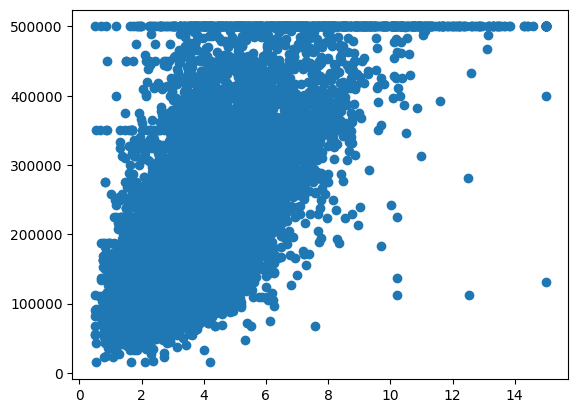

In [77]:
plt.scatter(X_train, y_train)

## 模型拟合

In [101]:
from sklearn.compose import TransformedTargetRegressor
# 普通OLS回归
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
# 计算训练集和测试集的均方误差MSE
lr_train_mse = mean_squared_error(
    y_train, lr.predict(X_train), squared=False)
# squared=False 表示取均方根误差
lr_test_mse = mean_squared_error(
    y_test, lr.predict(X_test), squared=False)
# 计算训练集和测试集的平均偏差MAE
lr_train_mae = mean_absolute_error(
    y_train, lr.predict(X_train))
lr_test_mae = mean_absolute_error(
    y_test, lr.predict(X_test))

# Ransac回归
ransac = linear_model.RANSACRegressor()
ransac.fit(X_train, y_train)
# 计算训练集和测试集的均方误差MSE
ransac_train_mse = mean_squared_error(
    y_train, ransac.predict(X_train), squared=False)
ransac_test_mse = mean_squared_error(
    y_test, ransac.predict(X_test), squared=False)
ransac_train_mae = mean_absolute_error(
    y_train, ransac.predict(X_train))
ransac_test_mae = mean_absolute_error(
    y_test, ransac.predict(X_test))

# Huber回归
huber = linear_model.HuberRegressor()
huber.fit(X_train, y_train)
# 计算训练集和测试集的均方误差MSE
huber_train_mse = mean_squared_error(
    y_train, huber.predict(X_train), squared=False)
huber_test_mse = mean_squared_error(
    y_test, huber.predict(X_test), squared=False)
huber_train_mae = mean_absolute_error(
    y_train, huber.predict(X_train))
huber_test_mae = mean_absolute_error(
    y_test, huber.predict(X_test))

# Theilsen回归
theilsen = linear_model.TheilSenRegressor()
theilsen.fit(X_train, y_train)
# 计算训练集和测试集的均方误差MSE
theilsen_train_mse = mean_squared_error(
    y_train, theilsen.predict(X_train), squared=False)
theilsen_test_mse = mean_squared_error(
    y_test, theilsen.predict(X_test), squared=False)
theilsen_train_mae = mean_absolute_error(
    y_train, theilsen.predict(X_train))
theilsen_test_mae = mean_absolute_error(
    y_test, theilsen.predict(X_test))

# 分位数回归
quant = sm.QuantReg(y_train, X_train)
quantreg = quant.fit(q=quantiles)
quant_train_mse = mean_squared_error(
    y_train, quantreg.predict(X_train), squared=False)
quant_test_mse = mean_squared_error(
    y_test, quantreg.predict(X_test), squared=False)
quant_train_mae = mean_absolute_error(
    y_train, quantreg.predict(X_train))
quant_test_mae = mean_absolute_error(
    y_test, quantreg.predict(X_test))

result = pd.DataFrame(
    {"beta": [lr.coef_[0][0], ransac.estimator_.coef_[0][0], huber.coef_[0], theilsen.coef_[0], quantreg.params[0]],
     "train_mse": [lr_train_mse, ransac_train_mse, huber_train_mse, theilsen_train_mse, quant_train_mse],
     "test_mse": [lr_test_mse, ransac_test_mse, huber_test_mse, theilsen_test_mse, quant_test_mse],
     "train_mae": [lr_train_mae, ransac_train_mae, huber_train_mae, theilsen_train_mae, quant_train_mae],
     "test_mae": [lr_test_mae, ransac_test_mae, huber_test_mae, theilsen_test_mae, quant_test_mae]})
result.index = ["lr_reg", "ransac_reg",
                "huber_reg", "theilsen_reg", "quantiles_reg"]
result

,beta,train_mse,test_mse,train_mae,test_mae
lr_reg,41711.505111,83798.543870,83583.677889,62724.596823,62262.595894
ransac_reg,42875.131305,87844.380769,87902.493849,61684.140827,61089.382032
huber_reg,43098.805136,84796.996030,84706.248283,61156.727035,60628.362719
theilsen_reg,44329.529629,86045.379247,86011.804270,61137.913824,60538.296387
quantiles_reg,40741.721862,97042.364778,97292.733916,67479.695872,67194.413488


## 绘制图进行对比

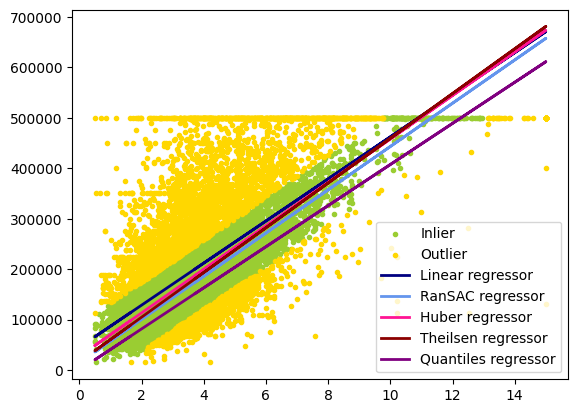

In [110]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
# 转换成数组
# X_train =X_train.to_numpy()
lr_y = lr.predict(X_train)
ransac_y = ransac.predict(X_train)
huber_y = huber.predict(X_train)
theilsen_y = theilsen.predict(X_train)
quantreg_y = quantreg.predict(X_train)

plt.scatter(X_train[inlier_mask], y_train[inlier_mask],
            color="yellowgreen", marker=".", label="Inlier")
plt.scatter(X_train[outlier_mask], y_train[outlier_mask],
            color="gold", marker=".", label="Outlier")


plt.plot(X_train, lr_y, color="navy", linewidth=2, label="Linear regressor")
plt.plot(X_train, ransac_y, color="cornflowerblue",
         linewidth=2, label="RanSAC regressor")
plt.plot(X_train, huber_y, color="deeppink",
         linewidth=2, label="Huber regressor")
plt.plot(X_train, theilsen_y, color="darkred",
         linewidth=2, label="Theilsen regressor")
plt.plot(X_train, quantreg_y, color="purple",
         linewidth=2, label="Quantiles regressor")
plt.legend()

plt.show()